# Import Libraries

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

# Load Data

In [156]:
data = pd.read_csv("/mnt/d/Datasets/AirPassengers.csv")
values = data["#Passengers"].values

In [157]:
window_size = 1
inputs = np.array([values[i:i+window_size] for i in range(len(values) - window_size)])
targets = values[window_size:]

In [158]:
train_size = 120
X_train, X_test = inputs[:train_size], inputs[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Echo State Network

In [ ]:
class EchoStateNetwork:
    def __init__(self, n_input, n_reservoir, n_output, spectral_radius=0.95, sparsity=0.1):
        self.n_input, self.n_reservoir, self.n_output = n_input, n_reservoir, n_output

        self.W_in = np.random.uniform(-1, 1, (n_reservoir, n_input))
        self.W = self._initialize_reservoir(n_reservoir, spectral_radius, sparsity)
        self.W_out = None
        
        self.reservoir_state = np.zeros(n_reservoir)

    def _initialize_reservoir(self, n_reservoir, spectral_radius, sparsity):
        W = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
        W *= np.random.rand(*W.shape) < sparsity
        return W * (spectral_radius / np.max(np.abs(np.linalg.eigvals(W))))

    def fit(self, inputs, targets, ridge_param=1e-6):
        states = [self._update_state(u) for u in inputs]
        states_augmented = np.hstack((np.array(states), inputs))

        self.W_out = np.linalg.solve(
            np.dot(states_augmented.T, states_augmented) + ridge_param * np.eye(states_augmented.shape[1]),
            np.dot(states_augmented.T, targets)
        ).T

    def predict(self, inputs):
        return np.array([
            np.dot(self.W_out.T, np.hstack((self._update_state(u), u))) for u in inputs
        ])

    def _update_state(self, input_data):
        self.reservoir_state = np.tanh(
            np.dot(self.W_in, input_data) + np.dot(self.W, self.reservoir_state)
        )
        return self.reservoir_state

# Train

In [161]:
esn = EchoStateNetwork(n_input=1, n_reservoir=100, n_output=1, spectral_radius=0.9, sparsity=0.1)

In [162]:
esn.fit(X_train, y_train)

# Results

In [163]:
predictions = esn.predict(X_test)

In [183]:
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))
print("RMSE = ", rmse)

RMSE =  53.148127397843936


In [185]:
nrmse = rmse / (max(y_test) - min(y_test))
print("NRMSE = ", nrmse)

NRMSE =  0.1898147407065855


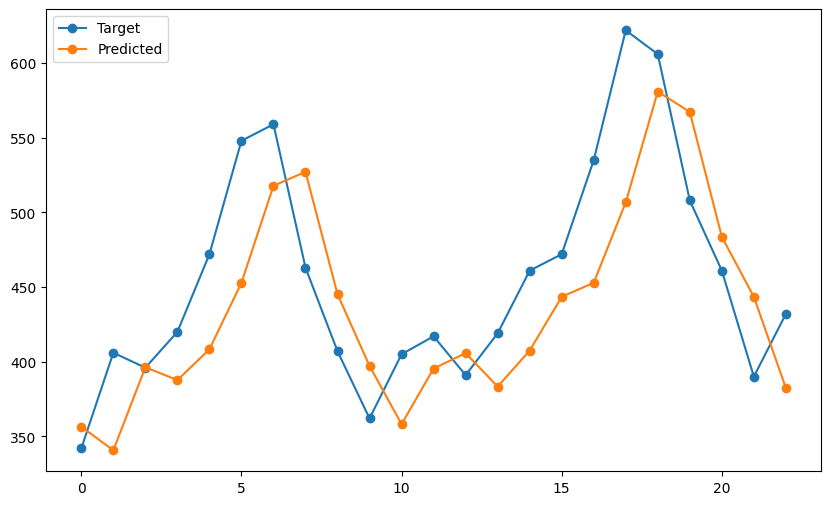

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(y_test)), y_test, marker="o")
plt.plot(range(0, len(predictions)), predictions, marker="o")
plt.legend(["Target", "Predicted"], loc="upper left")
plt.show()